In [1]:
import os, tempfile
import logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.ical_li import (li_act_and_tau,
                                 li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

In [5]:
modelfile = 'models/standardised_ical.mmt'

## Plot steady-state and tau functions

In [6]:
from ionchannelABC.visualization import plot_variables

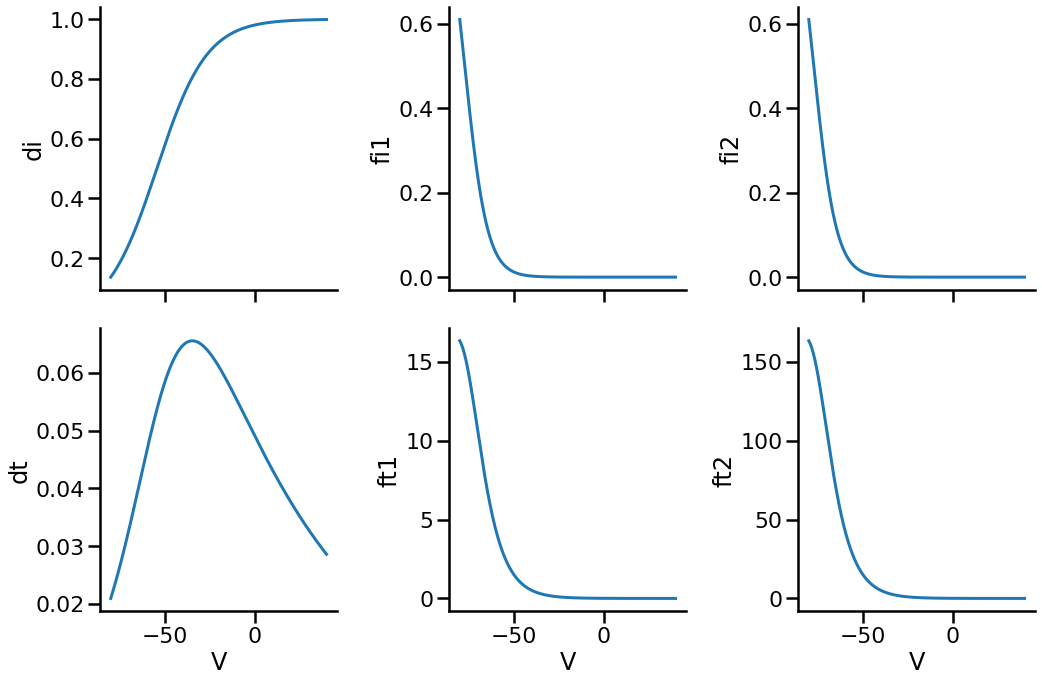

In [7]:
sns.set_context('poster')

V = np.arange(-80, 40, 0.01)

sta_vars = {'di': 'ical.d_ss',
            'fi1': 'ical.f_ss',
            'fi2': 'ical.f_ss',
            'dt':  'ical.tau_d',
            'ft1': 'ical.tau_f1',
            'ft2': 'ical.tau_f2'}

f, ax = plot_variables(V, sta_vars, 'models/standardised_ical.mmt', figshape=(3,2))

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act_and_tau,
                                                li_inact_1000,
                                                li_inact_kin_80,
                                                li_recov)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

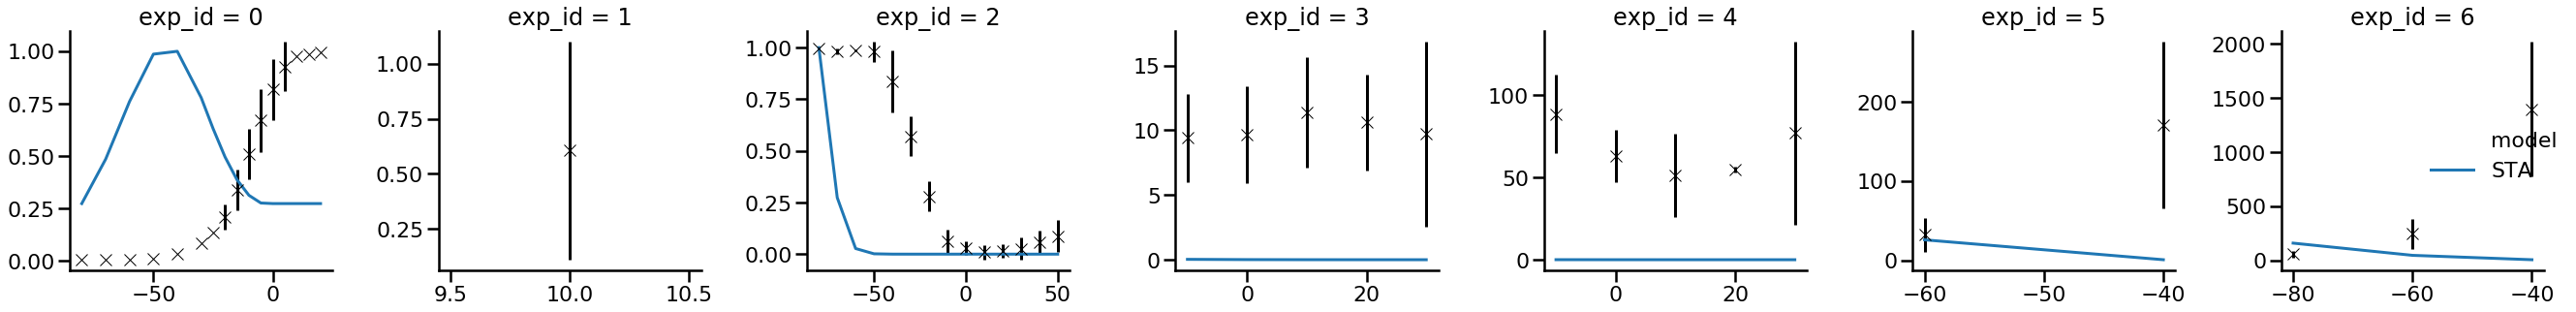

In [10]:
g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov)

In [11]:
limits = {'log_ical.p_1': (-7, 3),
          'ical.p_2': (1e-7, 0.4),
          'log_ical.p_3': (-7, 3),
          'ical.p_4': (1e-7, 0.4),
          'log_ical.p_5': (-7, 3),
          'ical.p_6': (1e-7, 0.4),
          'log_ical.p_7': (-7, 3),
          'ical.p_8': (1e-7, 0.4),
          'log_ical.A': (0., 3.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "standardised_ical.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 512 particles


In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9678753977594495, '1': 0.9678753977594495, '2': 0.9678753977594495, '3': 0.9678753977594495, '4': 0.9678753977594495, '5': 0.9678753977594495, '6': 0.9678753977594495, '7': 0.8108388442136876, '8': 0.4949276062083544, '9': 0.40434403902433114, '10': 0.3182415505473346, '11': 0.32995173747223605, '12': 0.4054194221068438, '13': 0.9678753977594495, '14': 0.9678753977594495, '15': 0.9678753977594495, '16': 0.948320343641584, '17': 1.106143311725085, '18': 1.106143311725085, '19': 1.106143311725085, '20': 1.106143311725085, '21': 0.3661134182449056, '22': 0.5684392546434062, '23': 0.7593993167501771, '24': 0.9437195392623547, '25': 1.106143311725085, '26': 1.106143311725085, '27': 1.106143311725085, '28': 1.0340756653619416, '29': 0.9437195392623547, '30': 0.7095117703943247, '31': 0.5182027705336358, '32': 0.47053527060396233, '33': 0.4147752932240028, '34': 0.47137080052372676, '35': 0.24685138829306388, '36': 0.5737108704898386, '37': 0.86131728575

In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-10-18 17:22:03.606784, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Database results analysis

In [20]:
history = History(db_path)

In [21]:
df, w = history.get_distribution(m=0)

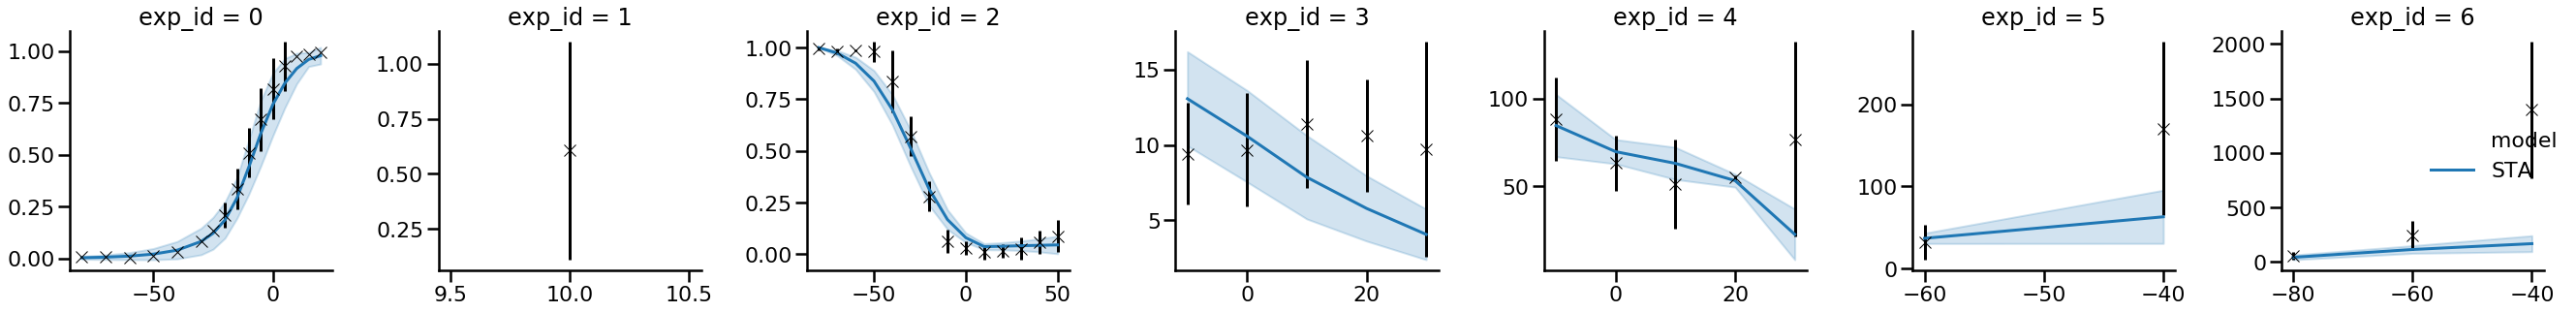

In [22]:
g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov,
                     df=df, w=w)

In [23]:
sta_pars = df.sample(n=100, weights=w, replace=True)
sta_pars = sta_pars.set_index([pd.Index(range(100))])
sta_pars = sta_pars.to_dict(orient='records')

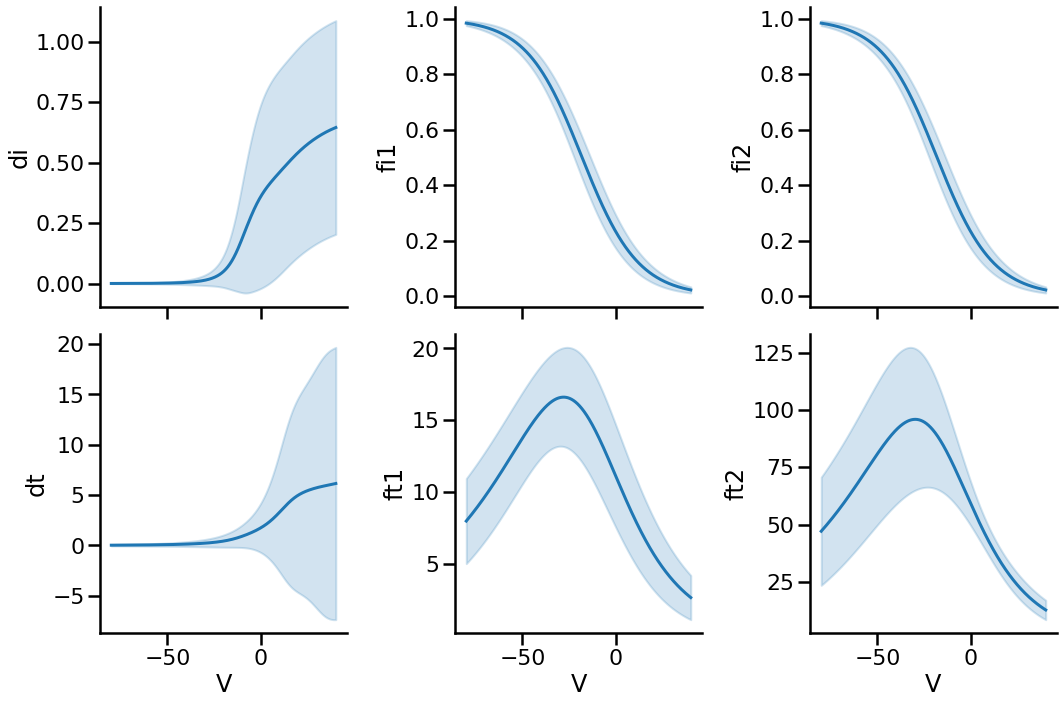

In [24]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, sta_vars, 
                       'models/standardised_ical.mmt', 
                       [sta_pars],
                       figshape=(3,2))

In [25]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [26]:
m,_,_ = myokit.load(modelfile)

In [27]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

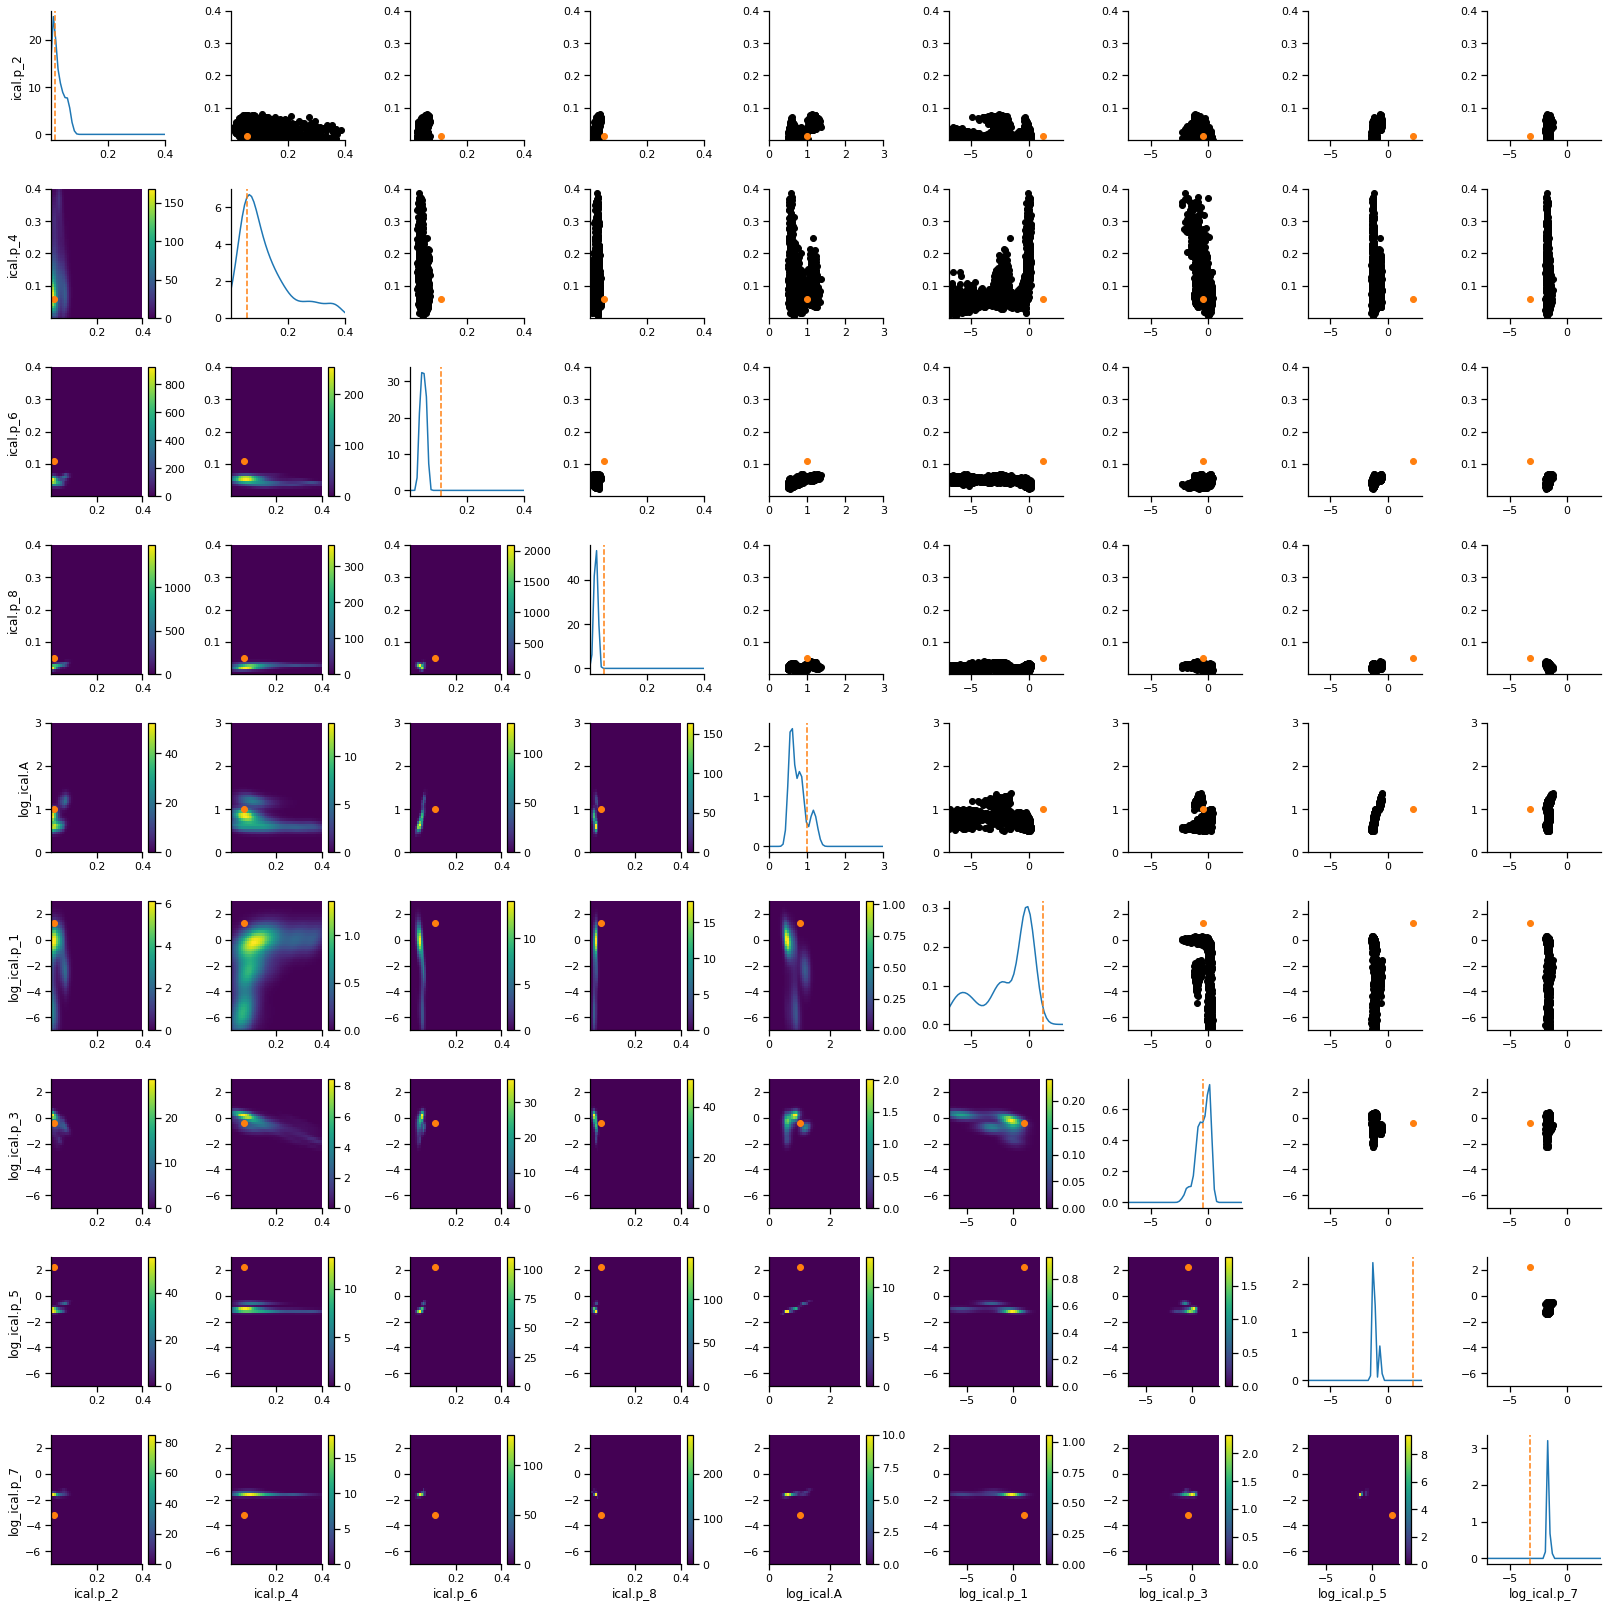

In [28]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)